In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet
import yfinance as yf
import os
import csv

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'TURBO'
yf_crypto = 'TURBO'

# Set YF crypto symbol
symbol = f'{yf_crypto}-USD'

# Create crypto df
#crypto_df = f'{crypto}_df'.lower()

In [5]:
# Retreive max data
data = yf.Ticker(f'{symbol}')
history = data.history(period='max')

# Define file path and name
#filepath = f'~/crypto-forecast/resources/{crypto}-USD.csv'
#filepath = os.path.expanduser('~/crypto-forecast/resources/ADA-USD.csv')

# Create dataframe
crypto_df = pd.DataFrame(history)

# Set 'Date' as the index and parse dates
crypto_df.index = pd.to_datetime(crypto_df.index)

# Drop columns
crypto_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Drop last row
crypto_df = crypto_df.drop(crypto_df.tail(1).index)

# Drop rows with any NaN values
crypto_df.dropna(inplace=True)

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Drop timezone from datetime
crypto_df = crypto_df.reset_index()
crypto_df['Date'] = crypto_df['Date'].dt.tz_localize(None)
crypto_df.set_index('Date', inplace=True)

# Set file path to store data as a csv
csv_filepath = os.path.expanduser(f'~/crypto-forecast/resources/{crypto}-USD.csv')

# Write the DataFrame to a CSV file
crypto_df.to_csv(csv_filepath, index=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2023-05-04,0.000656,0.000656,0.000287,0.000317,39461136
2023-05-05,0.000317,0.001399,0.000225,0.001266,101798162
2023-05-06,0.001269,0.003049,0.001269,0.002314,266556227
2023-05-07,0.002304,0.002360,0.001286,0.001299,132793196
2023-05-08,0.001299,0.001508,0.000518,0.001117,132340372


,Open,High,Low,Close,Volume
Date,,,,,
2024-06-04,0.006343,0.006924,0.006017,0.006448,114203563
2024-06-05,0.006448,0.006463,0.005853,0.006039,108301662
2024-06-06,0.006039,0.006491,0.005930,0.006176,99777837
2024-06-07,0.006176,0.006279,0.004814,0.005194,102149172
2024-06-08,0.005193,0.005447,0.005072,0.005137,69481637


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

0.0051369997672736645

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.985747,0.990386,0.973649,0.832351
High,0.985747,1.000000,0.986078,0.994722,0.889089
Low,0.990386,0.986078,1.000000,0.986341,0.812306
Close,0.973649,0.994722,0.986341,1.000000,0.873552
Volume,0.832351,0.889089,0.812306,0.873552,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2023-05-04,0.000317,39461136
2023-05-05,0.001266,101798162
2023-05-06,0.002314,266556227
2023-05-07,0.001299,132793196
2023-05-08,0.001117,132340372
...,...,...
2024-06-04,0.006448,114203563
2024-06-05,0.006039,108301662
2024-06-06,0.006176,99777837


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2023-06-22,0.000192,7176545,0.000165,0.000199,0.000458
2023-06-23,0.000221,9860876,0.000177,0.000194,0.000457
2023-06-24,0.000243,11719184,0.000188,0.000190,0.000436
2023-06-25,0.000202,6479279,0.000192,0.000183,0.000394
2023-06-26,0.000195,4368512,0.000195,0.000178,0.000372


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-06-04,0.006448,114203563,0.006956,0.003329,0.002236
2024-06-05,0.006039,108301662,0.007074,0.003507,0.002346
2024-06-06,0.006176,99777837,0.006910,0.003688,0.002459
2024-06-07,0.005194,102149172,0.006485,0.003839,0.002551
2024-06-08,0.005137,69481637,0.006277,0.003978,0.002643


<Axes: xlabel='Date'>

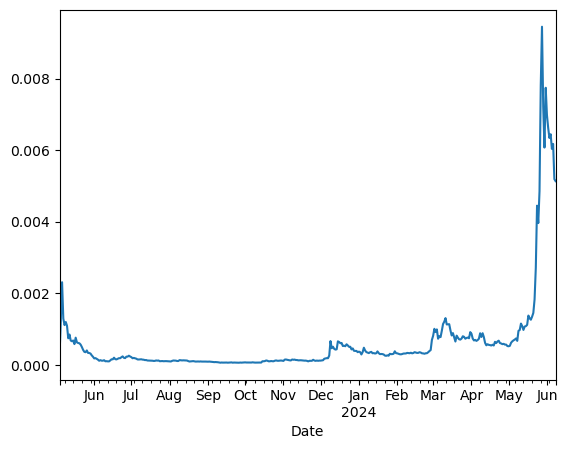

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2023-05-04,0.000317,39461136
1,2023-05-05,0.001266,101798162
2,2023-05-06,0.002314,266556227
3,2023-05-07,0.001299,132793196
4,2023-05-08,0.001117,132340372
...,...,...,...
397,2024-06-04,0.006448,114203563
398,2024-06-05,0.006039,108301662
399,2024-06-06,0.006176,99777837
400,2024-06-07,0.005194,102149172


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

17:06:32 - cmdstanpy - INFO - Chain [1] start processing
17:06:33 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
487,2024-09-02
488,2024-09-03
489,2024-09-04
490,2024-09-05
491,2024-09-06


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
462,2024-08-08,0.005944,0.004848,0.006942,0.005778,0.006131,-0.000036,-0.000036,-0.000036,-0.000036,-0.000036,-0.000036,0.0,0.0,0.0,0.005908
463,2024-08-09,0.005982,0.004935,0.007055,0.005812,0.006175,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.0,0.0,0.0,0.006010
464,2024-08-10,0.006020,0.004925,0.007083,0.005847,0.006219,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.0,0.0,0.0,0.006043
465,2024-08-11,0.006058,0.004911,0.007148,0.005879,0.006263,-0.000026,-0.000026,-0.000026,-0.000026,-0.000026,-0.000026,0.0,0.0,0.0,0.006032
466,2024-08-12,0.006096,0.005052,0.007229,0.005914,0.006306,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.0,0.0,0.0,0.006109
467,2024-08-13,0.006134,0.005082,0.007214,0.005947,0.006349,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.0,0.0,0.0,0.006156
468,2024-08-14,0.006172,0.005013,0.007252,0.005980,0.006392,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,-0.000024,0.0,0.0,0.0,0.006148
469,2024-08-15,0.006210,0.005120,0.007213,0.006014,0.006435,-0.000036,-0.000036,-0.000036,-0.000036,-0.000036,-0.000036,0.0,0.0,0.0,0.006174
470,2024-08-16,0.006248,0.005132,0.007459,0.006047,0.006479,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.0,0.0,0.0,0.006276
471,2024-08-17,0.006286,0.005277,0.007361,0.006081,0.006524,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.0,0.0,0.0,0.006309


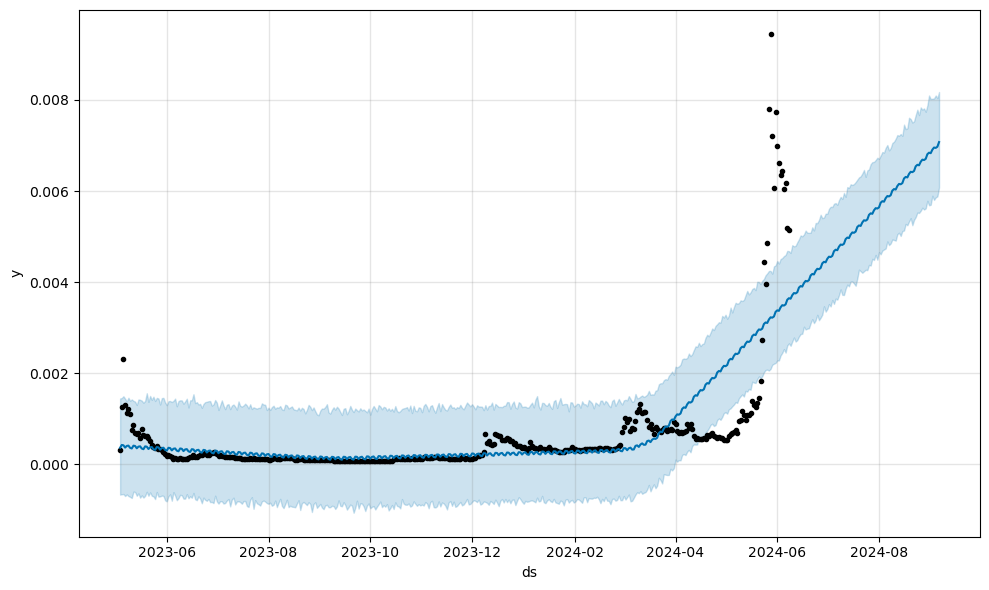

In [20]:
# Plot the Prophet predictions for the data
crypto_model.plot(crypto_forecast)
plt.savefig(f'{crypto}_forecast', bbox_inches = 'tight')

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-06-09,0.003635,0.002601,0.004640
2024-06-10,0.003712,0.002695,0.004810
2024-06-11,0.003759,0.002782,0.004786
2024-06-12,0.003751,0.002694,0.004796
2024-06-13,0.003777,0.002725,0.004874
...,...,...,...
2024-09-02,0.006909,0.005896,0.008026
2024-09-03,0.006955,0.005804,0.008035
2024-09-04,0.006947,0.005860,0.008098


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

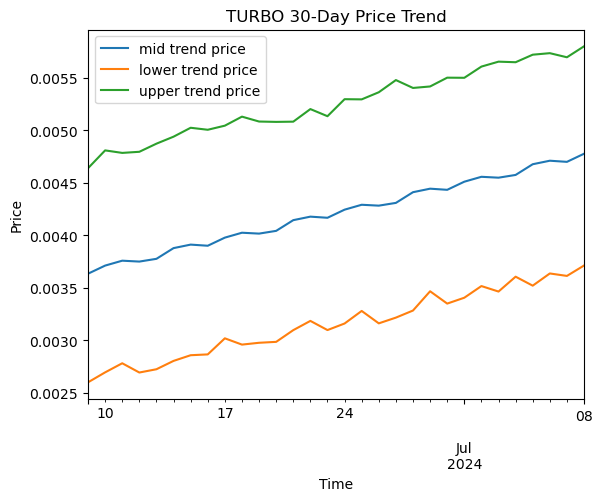

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

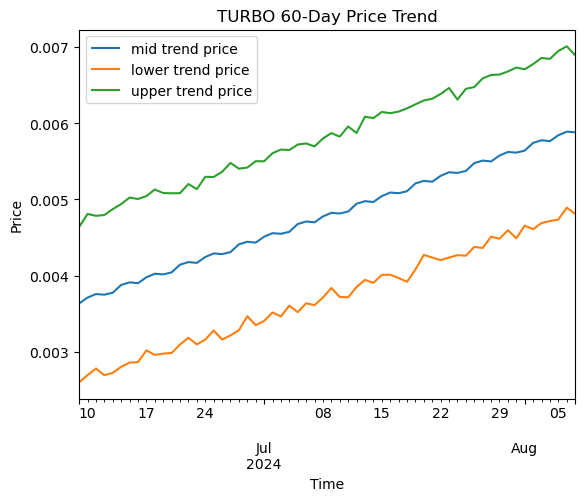

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

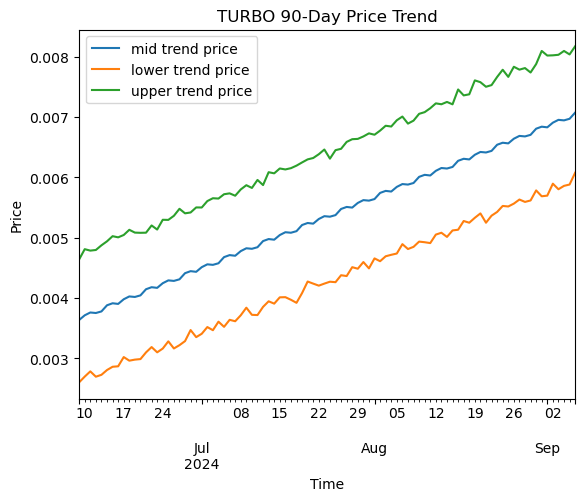

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

0.0051369997672736645

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

0.003635082771180819

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

0.0043860412692272414

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

0.0036291339648040133

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

0.004836692887091352

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

0.005902666514781004

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

0.007095618786129696

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

0.103

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

0.346

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

0.618

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

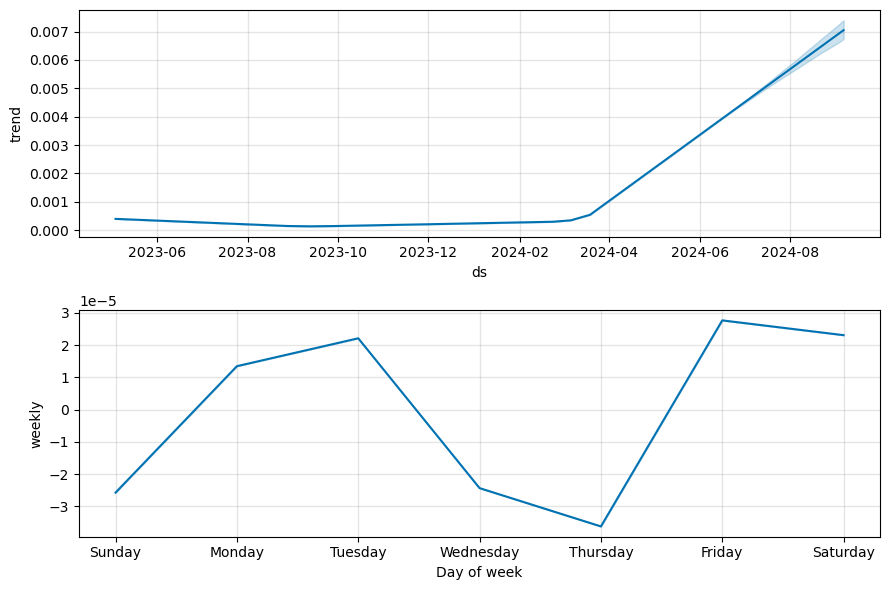

In [38]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

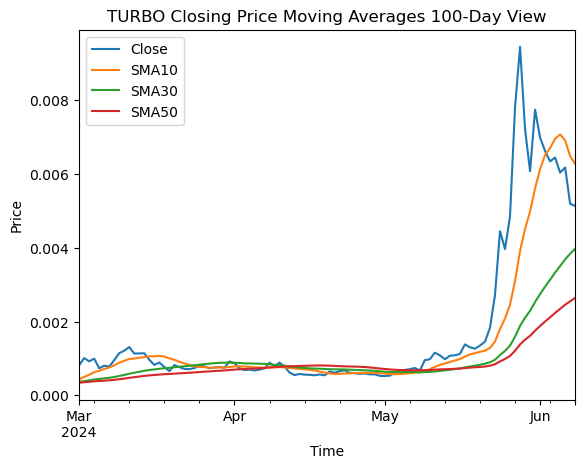

In [39]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

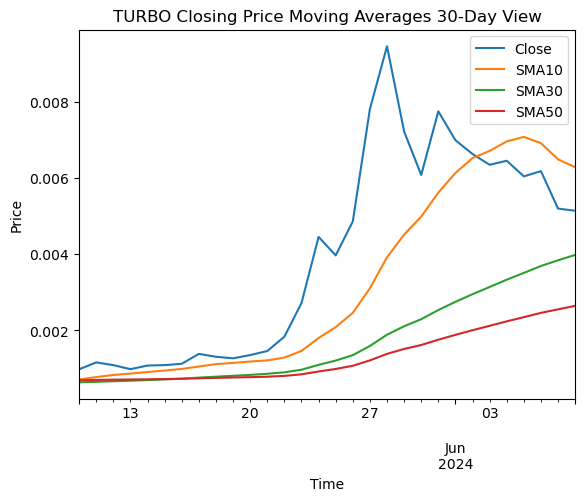

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View') 
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [41]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-06-09
File created :  2024-06-09.csv


In [42]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [43]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.43657100200653076,-0.07364667494769794,-0.0009456964793739253,0.3544596118546628
ADA,0.43657100200653076,-0.08437373181845453,0.002834181787628731,0.36173019111251126
ADA,0.43657100200653076,-0.08372637062435029,0.0025919668069758206,0.3631142967037635
ADA,0.43657100200653076,-0.0783190338427533,0.004381382002310641,0.36321329122708335
ATOM,7.759523868560791,-0.2525451407294217,-0.22995154564524733,0.08676291965413196
AVAX,32.29003143310547,-0.06238204683353343,0.016250905637703372,0.184324988794629
AVAX,32.29003143310547,-0.061383912293528464,0.006255814491331391,0.188757389641659
BNB,682.6651611328125,-0.25945675235825627,-0.21619087415535265,-0.19462572272913758
BONK,2.700000004551839e-05,0.19694570130627698,0.3277996886564134,0.4415377509818921
BTC,69305.7734375,-0.1351637782567381,-0.09261706566887273,-0.09372540555309616
DOGE,0.14605900645256042,-0.18446710000937716,-0.08920949588743987,-0.03966410323402325
ETH,3680.949951171875,-0.11161221692021561,-0.03134563847923688,-0.